<h4>Imports</h4>

In [70]:
#NOTE: autoreload is not recursive, only direct imports are reloaded
%load_ext autoreload
%autoreload 2
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment, Schedule
from solver import GASolver, PSOSolver, GreedyAgentSolver
from visualize import visualize_schedule_demo, compare_results
import objective_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [71]:
available_solvers = ["GASolver", "PSOSolver", "GreedyAgentSolver"]
use_solver = available_solvers[0]
save_file = False
file_name = 'just_testing' # NOTE: only change this name for saving files

full_name = f'{file_name}_{use_solver}'

<h4>Read from Source</h4>

In [72]:
n_workstations, recipes, operation_times = get_data(0)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

<h4>Create Orders</h4>

In [73]:
earliest_slot = 0
last_slot = 100
#recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3, 0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, last_slot, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


<h4>Translate for Solver</h4>

In [74]:
if use_solver == "GASolver" or use_solver == "PSOSolver" or use_solver == "GreedyAgentSolver": # NOTE: all solvers use the same encoding right now
    # translate datamodel to encoding
    encoder = EncodeForGA()
    values, durations, all_jobs = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job


<h4>Run Solver</h4>

GA

In [75]:
if use_solver == "GASolver":
    #NOTE: Best makespan so far: 22 for dataset 0 
    crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
    selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stochastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
    mutation = 'workstation_only' #NOTE: available options: 'workstation_only', 'full_random', 'random_only_feasible' #NOTE 2: so far only workstation_only can find feasible results
    objective = 'makespan' #NOTE: available options: 'makespan', 'idle_time'
    population_size = 25
    offspring_amount = 50
    max_generations = 1000

    solver = GASolver(values, durations, all_jobs, env, orders)
    solver.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective=objective)
    solver.run()

Done


In [76]:
if use_solver == "GASolver":
    # just for comparison, so the optimizers don't have to run over and over again
    ga_result = solver.get_best()
    ga_fitness = solver.get_best_fitness()

PSO 

In [77]:
if use_solver == "PSOSolver":
    #NOTE: no best makespan yet
    solver = PSOSolver(values, durations, all_jobs, env, orders)

    #solver.initialize(earliest_slot, last_slot, c1=0.5, c2=0.3, w=0.5, max_iter=5000)
    solver.initialize(earliest_slot, last_slot, c1=2, c2=2, w=0.1, max_iter=25000) # 'widely used values for integer optimization' https://www.researchgate.net/publication/3949434_Particle_swarm_optimization_for_integer_programming
    solver.run()

In [78]:
if use_solver == "PSOSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    pso_result = solver.get_best()
    pso_fitness = solver.get_best_fitness()

Greedy Agent

In [79]:
if use_solver == "GreedyAgentSolver":
    #NOTE: Best makespan so far: 26 for dataset 0
    solver = GreedyAgentSolver(values, durations, all_jobs, env, orders)
    solver.run()

In [80]:
if use_solver == "GreedyAgentSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    greedy_result = solver.get_best()
    greedy_fitness = solver.get_best_fitness()

<h4>Result Output</h4>

In [81]:
result = solver.get_best()
fitness = solver.get_best_fitness()
#result = greedy_result
#fitness = greedy_fitness
#result = pso_result
#fitness = pso_fitness
#result = ga_result
#fitness = ga_fitness

print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 3  0  1  1  3  5  4  0  3  9  1 17  0  0  4  9  3 17  3 19  0  9  2 10
  1  5  0 10  3 20  2 12  3 24  1  5  0 15  3 25  2 27  2 14  4 18  4 23
  4 13  0 21  0 26  0 30  3 31  4 13  1 15  1 19  0 31  1 33  4 39  2 14
  3 32  0 37  0 39  0 33  4 44  4 13  1 24  2 28  1  5  2 14  3  1  4 15
  4 19  2 23  4 13  2 25  2 34  2 14  1 24  0 34  2 14  2 20]
Fitness value of the best solution = 200


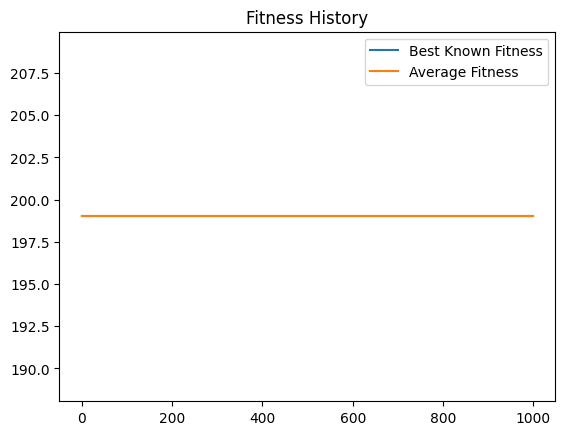

In [82]:
import matplotlib.pyplot as plt
if not len(fitness_history) == 0 and not len(average_fitness_history) == 0:
    x = list(range(0, len(fitness_history)))
    plt.plot(x, fitness_history)
    plt.plot(x, average_fitness_history)
    plt.title('Fitness History')
    plt.legend(['Best Known Fitness', 'Average Fitness'])
    plt.xlabel = 'Generation'
    plt.ylabel = 'Fitness'
    plt.show()

<h4>(Optional) Postprocessing</h4>

<h4>Translate to Schedule</h4>

In [83]:
schedule = GAToScheduleTranslator().translate(result, all_jobs, env, orders)
schedule.created_in = env
schedule.created_for = orders

<h4>Visualize Schedule</h4>

In [84]:
visualize_schedule_demo(schedule, env, orders)

<h4>Evaluate Schedule</h4>

In [85]:
#NOTE: the objective functions in this case assume the solution is feasible, no additional checks
#NOTE: currently the only objective function used during optimization is makespan
fitness_values = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespan: {fitness_values[0]}\nTardiness: {fitness_values[1]}\nDeviation: {fitness_values[2]}\nIdle Time: {fitness_values[3]}\nProfit: {fitness_values[4]}')

Fitness Values:
Makespan: 46
Tardiness: 0
Deviation: 1440
Idle Time: -24
Profit: 10000


(Optional) Save Result as .pickle file for later comparison

In [86]:
import pickle

solver.environment = None # make file smaller, since the schedule already knows the environment and the orders
solver.orders = None
schedule.created_by = solver
schedule.evaluation_results = []
schedule.evaluation_results.append(('makespan', fitness_values[0]))
schedule.evaluation_results.append(('tardiness', fitness_values[1]))
schedule.evaluation_results.append(('deviation', fitness_values[2]))
schedule.evaluation_results.append(('idle_time', fitness_values[3]))
schedule.evaluation_results.append(('profit', fitness_values[4]))

if(save_file):
    with open(f'results/{full_name}.pickle', 'wb') as outfile:
        pickled_data = pickle.dump(schedule, outfile)


<h1> ####### MAS TESTING SECTION #######  </h1>

In [93]:
from mas import MAS
# GA config
crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stochastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
mutation = 'workstation_only' #NOTE: available options: 'workstation_only', 'full_random', 'random_only_feasible' #NOTE 2: so far only workstation_only can find feasible results

population_size = 50
offspring_amount = 100
max_generations = 5000
s1 = GASolver(values, durations, all_jobs, env, orders)
s1.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective='makespan')
s2 = GASolver(values, durations, all_jobs, env, orders)
s2.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective='idle_time')
s3 = GreedyAgentSolver(values, durations, all_jobs, env, orders)

mas = MAS()
mas.add_solver(s1, GAToScheduleTranslator())
mas.add_solver(s2, GAToScheduleTranslator())
mas.add_solver(s3, GAToScheduleTranslator())

In [94]:
schedule = mas.run(env=env, jobs=all_jobs, orders=orders, parallel=False) # NOTE: parallel runs can be problematic with jupyter notebooks

Done
Done
Done


In [95]:
def show_result(result : tuple) -> None:
    print('####################################################################################################')
    print(f'Created with {result[0].created_by.name} for objective: {result[0].created_by.objective}')
    visualize_schedule_demo(result[0], env, orders)
    print(f'Fitness Values:\nMakespan: {result[1][0]}\nTardiness: {result[1][1]}\nDeviation: {result[1][2]}\nIdle Time: {result[1][3]}\nProfit: {result[1][4]}')

In [96]:
show_result(schedule)

####################################################################################################
Created with GreedyAgentSolver for objective: makespan


Fitness Values:
Makespan: 60
Tardiness: 0
Deviation: 1356
Idle Time: 0
Profit: 10000


In [97]:
all_results = mas.get_all_results()

for result in all_results:
    show_result(result)

print(f'\nDominance Values:')
for i in range(len(all_results)):
    print(f'{all_results[i][0].created_by.name}, {all_results[i][0].created_by.objective}: {mas.get_dominance(all_results, i)}')

####################################################################################################
Created with GASolver for objective: makespan


Fitness Values:
Makespan: 126
Tardiness: 68
Deviation: 789
Idle Time: 199
Profit: 9500
####################################################################################################
Created with GASolver for objective: idle_time


Fitness Values:
Makespan: 121
Tardiness: 63
Deviation: 1074
Idle Time: 124
Profit: 9500
####################################################################################################
Created with GreedyAgentSolver for objective: makespan


Fitness Values:
Makespan: 60
Tardiness: 0
Deviation: 1356
Idle Time: 0
Profit: 10000

Dominance Values:
GASolver, makespan: 2
GASolver, idle_time: 1
GreedyAgentSolver, makespan: 3


Value Comparison

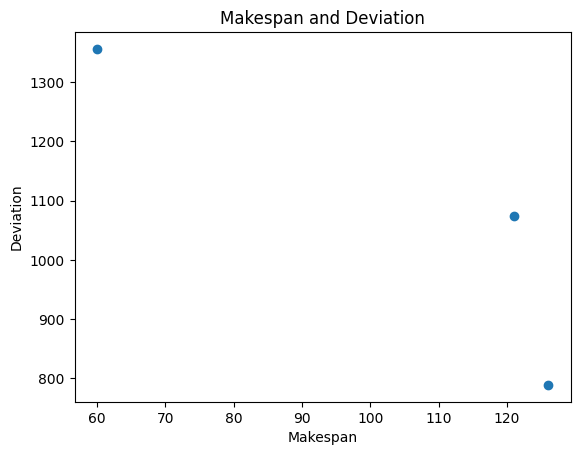

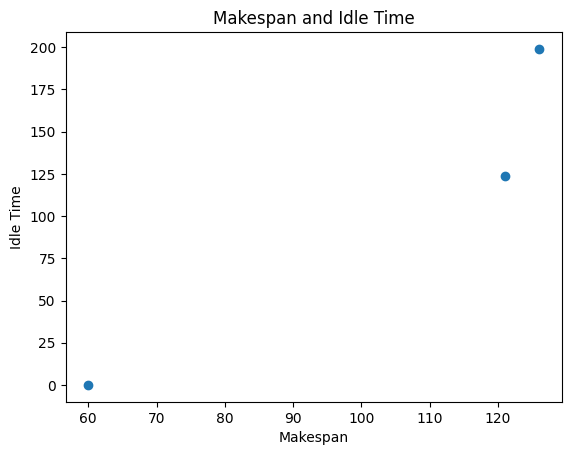

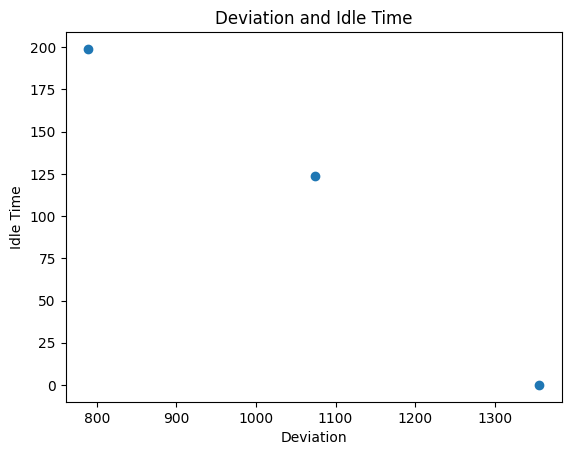

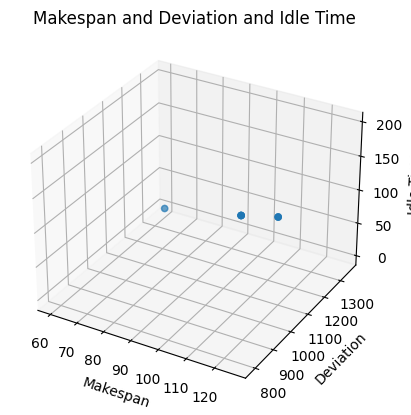

In [98]:
compare_results(all_results, ['Makespan', 'Tardiness', 'Deviation', 'Idle Time', 'Profit'], ignore=[1, 4], remap_values=False)